In [1]:
from pathlib import Path
import numpy as np
from snirf import Snirf
import mne
from mne_nirs.io import write_raw_snirf
from snirf import validateSnirf
import os
import snirf
from mne.io import read_raw_nirx, read_raw_snirf
from mne.preprocessing.nirs import beer_lambert_law, optical_density
from numpy.testing import assert_allclose

In [2]:
# homer3_to_mne_compatible.py
#
#
# - Take Homer3 HbO/HbR/HbT SNIRF
# - Drop HbT channels
# - Keep measurementList as a proper pysnirf2 IndexedGroup
# - Save a new SNIRF that mne.io.read_raw_snirf can read as hbo/hbr


# ------------------------------------------------------------
# 1) INPUT / OUTPUT PATHS  -----------------------------------
# ------------------------------------------------------------
in_fname = Path(
    "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb.snirf"
)

out_fname = in_fname.with_name(in_fname.stem + "_mne.snirf")

print(f"Input SNIRF: {in_fname}")
print(f"Will write:  {out_fname}")

# ------------------------------------------------------------
# 2) LOAD SNIRF  ---------------------------------------------
# ------------------------------------------------------------
snirf = Snirf(str(in_fname))

# Assume single nirs element and single data block (true for Homer3 export)
nirs = snirf.nirs[0]
data = nirs.data[0]
ml = data.measurementList   # IMPORTANT: this is an IndexedGroup, not a list

# ------------------------------------------------------------
# 3) INSPECT dataTypeLabel AND BUILD KEEP MASK ---------------
# ------------------------------------------------------------
labels = [str(ml[i].dataTypeLabel) for i in range(len(ml))]
uniq = sorted(set(labels))
print("Unique dataTypeLabel values BEFORE:", uniq)

keep_mask = np.array(
    [(lab == "HbO") or (lab == "HbR") for lab in labels],
    dtype=bool,
)

n_total = len(labels)
n_keep = int(keep_mask.sum())

print(f"Total channels: {n_total}")
print(f"Keeping {n_keep} channels (HbO/HbR only)")
print(f"Dropping {n_total - n_keep} channels (e.g. HbT)")

# ------------------------------------------------------------
# 4) SLICE dataTimeSeries TO MATCH KEEP MASK -----------------
# ------------------------------------------------------------
ts = np.asarray(data.dataTimeSeries)
if ts.shape[1] != n_total:
    raise RuntimeError(
        f"dataTimeSeries has {ts.shape[1]} columns but measurementList has {n_total} entries"
    )

ts = ts[:, keep_mask]
data.dataTimeSeries = ts  # assign back (pysnirf2 accepts numpy arrays)

# ------------------------------------------------------------
# 5) DROP UNWANTED measurementList ENTRIES IN PLACE ----------
# ------------------------------------------------------------
# Do NOT do: data.measurementList = [...]
# Instead, delete entries from the existing IndexedGroup, from end to start.
for i in range(n_total - 1, -1, -1):
    if not keep_mask[i]:
        del ml[i]

# Sanity check
if len(ml) != n_keep:
    raise RuntimeError(
        f"After deletion, measurementList has {len(ml)} entries, expected {n_keep}"
    )

# ------------------------------------------------------------
# 6) SAVE NEW SNIRF  -----------------------------------------
# ------------------------------------------------------------
snirf.save(str(out_fname))
print("Done.")


Input SNIRF: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb.snirf
Will write:  /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne.snirf
Unique dataTypeLabel values BEFORE: ['HbO', 'HbR', 'HbT']
Total channels: 138
Keeping 92 channels (HbO/HbR only)
Dropping 46 channels (e.g. HbT)
Done.


In [3]:
# fix_landmarks_in_snirf.py

# 1) Path to the _mne.snirf file you just created
snirf_path = Path(
    "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne.snirf"
)

print("Opening:", snirf_path)

# 2) Open file for read/write (r+)
with Snirf(str(snirf_path), "r+") as snirf:
    probe = snirf.nirs[0].probe

    print("Before:")
    print("  landmarkPos3D:", probe.landmarkPos3D)
    print("  landmarkLabels:", probe.landmarkLabels)

    # 3) Remove landmarks (let them be None / absent)
    probe.landmarkPos3D = None
    probe.landmarkLabels = None

    # 4) Save in-place
    snirf.save()

    print("After:")
    print("  landmarkPos3D:", probe.landmarkPos3D)
    print("  landmarkLabels:", probe.landmarkLabels)

print("Done cleaning landmarks.")


Opening: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne.snirf
Before:
  landmarkPos3D: []
  landmarkLabels: None
After:
  landmarkPos3D: None
  landmarkLabels: None
Done cleaning landmarks.


In [6]:
# rewrite_snirf_with_mne_fixed.py

in_fname = (
    "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne.snirf"
)
out_clean = (
    "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf"
)

print("Loading", in_fname)
raw = mne.io.read_raw_snirf(in_fname, preload=True)

# --- Fix NaN wavelengths in raw.info['chs'] ---
for ch in raw.info["chs"]:
    wl = ch["loc"][9]
    if not np.isfinite(wl):
        name = ch["ch_name"]
        # Simple rule: assign dummy wavelength based on chromophore
        if name.endswith(" hbo"):
            ch["loc"][9] = 760.0   # or your real lambda1
        elif name.endswith(" hbr"):
            ch["loc"][9] = 850.0   # or your real lambda2
        else:
            # Fallback: just pick one
            ch["loc"][9] = 760.0

# --- Now write SNIRF using MNE-NIRS ---
print("Writing", out_clean)
write_raw_snirf(raw, out_clean)

# --- Validate with pysnirf2 ---
print("Validating with pysnirf2...")
res = validateSnirf(out_clean)
res.display()



Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
Writing /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf
Validating with pysnirf2...

Found 572 OK      (hidden)
Found 752 INFO    (hidden)
Found 0 WARNING
Found 0 FATAL  

File is VALID


In [8]:
# Check if .snirf file is loading and valid

file_path = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf"

out_fname = Path(file_path)

print("Loading", out_fname)
raw_hb = mne.io.read_raw_snirf(str(out_fname), preload=True)
print(raw_hb)
print(raw_hb.get_channel_types(unique=True))

result = validateSnirf(file_path)
assert result.is_valid()
result.display()


Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
<RawSNIRF | output_preproc_hb_mne_clean.snirf, 92 x 1740 (174.0 s), ~1.3 MiB, data loaded>
['hbo', 'hbr']

Found 572 OK      (hidden)
Found 752 INFO    (hidden)
Found 0 WARNING
Found 0 FATAL  

File is VALID


Loading SNIRF: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf
Loading /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf
Found jitter of 0.000000% in sample times.
Reading 0 ... 1739  =      0.000 ...   173.900 secs...
<RawSNIRF | output_preproc_hb_mne_clean.snirf, 92 x 1740 (174.0 s), ~1.3 MiB, data loaded>
Channel types: ['hbo', 'hbr']
Onset:  [ 23.046357  69.007572 115.017932]
Duration:  [36. 36. 36.]
Description:  ['add' 'add' 'control']
Detected haemoglobin data → using as-is
Remaining channels: 88
Design matrix columns: ['add', 'control', 'drift_1', 'drift_2', 'drift_3', 'constant']
     add  control   drift_1   drift_2   drift_3  constant
0.0  0.0      0.0  0.033903  0.033903  0.033903     

/var/folders/57/27nbkr8d6tjbj5ht598xbyzm0000gn/T/ipykernel_38545/248300473.py:82: DeprecationWarning: The parameter "ax" will be removed in 0.13.0 release of Nilearn. Please use the parameter "axes" instead.
  plot_design_matrix(design_matrix, ax=ax)


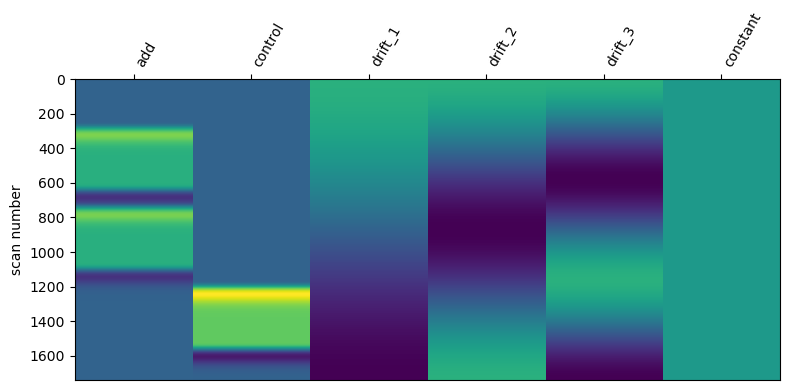

Fitting GLM...
variable Condition   df           mse   p_value        se         t     theta  \
240            add  6.0  1.652889e-11  0.000224  0.000008 -7.865164 -0.000066   
241       constant  6.0  1.652889e-11  0.000451  0.000009  6.918991  0.000059   
242        control  6.0  1.652889e-11  0.005152  0.000012 -4.289503 -0.000050   
243        drift_1  6.0  1.652889e-11  0.008744  0.000314  3.821636  0.001201   
244        drift_2  6.0  1.652889e-11  0.048514  0.000291  2.469149  0.000718   

variable  Source  Detector Chroma  Significant    ch_name  
240            1         1    hbo         True  S1_D1 hbo  
241            1         1    hbo         True  S1_D1 hbo  
242            1         1    hbo         True  S1_D1 hbo  
243            1         1    hbo         True  S1_D1 hbo  
244            1         1    hbo         True  S1_D1 hbo  
Saved GLM results to: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS

In [9]:
# glm_from_snirf.py

from pathlib import Path

import mne
import pandas as pd

from mne.preprocessing.nirs import optical_density, beer_lambert_law
from mne_nirs.channels import get_long_channels
from mne_nirs.experimental_design import make_first_level_design_matrix
from mne_nirs.statistics import run_glm

# -----------------------------
# 0) INPUTS (EDIT THESE)
# -----------------------------
snirf_path = Path("/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/output_preproc_hb_mne_clean.snirf")  # your valid SNIRF
out_csv    = Path("/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/glm_results.csv")



# -----------------------------
# 1) LOAD SNIRF
# -----------------------------
print(f"Loading SNIRF: {snirf_path}")
raw = mne.io.read_raw_snirf(snirf_path, preload=True)
print(raw)  # quick sanity check
print("Channel types:", raw.get_channel_types(unique=True))
print("Onset: ", raw.annotations.onset)
print("Duration: ", raw.annotations.duration)
print("Description: ", raw.annotations.description)

# Typical block length for your task (seconds)
STIM_DUR = raw.annotations.duration[0]   # change to your actual block duration

# -----------------------------
# 2) ENSURE HAEMOGLOBIN DATA
# -----------------------------
ch_types = raw.get_channel_types(unique=True)

if "fnirs_cw_amplitude" in ch_types:
    # Case A: SNIRF still contains intensity → convert to HbO/HbR
    print("Detected intensity data → converting to HbO/HbR")
    raw_od = optical_density(raw)
    raw_haemo = beer_lambert_law(raw_od)
elif any(ct in ("hbo", "hbr") for ct in ch_types):
    # Case B: already haemoglobin (typical for your Homer3 export)
    print("Detected haemoglobin data → using as-is")
    raw_haemo = raw.copy()
else:
    raise RuntimeError(
        "Unexpected channel types. Expected 'fnirs_cw_amplitude' or 'hbo'/'hbr'."
    )

# -----------------------------
# 3) KEEP ONLY LONG CHANNELS
# -----------------------------
# Removes short-separation channels; default 1.5–4.5 cm. 
raw_haemo = get_long_channels(raw_haemo)
print("Remaining channels:", len(raw_haemo.ch_names))

# (Optional) extra filter here if you *haven't* prefiltered in Homer3.
# raw_haemo = raw_haemo.filter(0.01, 0.2, verbose=False)

# -----------------------------
# 4) DESIGN MATRIX
# -----------------------------
# Uses raw_haemo.annotations (from SNIRF stim) to build regressors.
# Each unique description becomes a regressor. 
design_matrix = make_first_level_design_matrix(
    raw_haemo,
    stim_dur=STIM_DUR,
    hrf_model="glover"    # canonical HRF, like SPM
)

print("Design matrix columns:", list(design_matrix.columns))
print(design_matrix.head())

# If you have nilearn installed, you can visualise the design:
from nilearn.plotting import plot_design_matrix
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 4))
plot_design_matrix(design_matrix, ax=ax)
fig.tight_layout()
plt.show()

# -----------------------------
# 5) RUN GLM
# -----------------------------
# Wrapper around Nilearn's GLM; default AR(1) noise model. 
print("Fitting GLM...")
glm_est = run_glm(raw_haemo, design_matrix)

# glm_est is a RegressionResults object with GLM fits for all channels. 

# -----------------------------
# 6) EXPORT RESULTS
# -----------------------------
# Converts all GLM results to a tidy DataFrame:
# one row per (channel, condition, chroma) with theta, t, p, etc. 
df = glm_est.to_dataframe()
print(df.head())

df.to_csv(out_csv, index=False)
print(f"Saved GLM results to: {out_csv}")


Loading GLM results from: /Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/glm_results_bnkg.csv

Columns in file:
['Condition', 'df', 'mse', 'p_value', 'se', 't', 'theta', 'Source', 'Detector', 'Chroma', 'Significant', 'ch_name']

Number of significant channels (p < 0.050) per condition & chroma:
Condition Chroma  n_sig_channels
      add    hbo              30
      add    hbr              33
 constant    hbo              31
 constant    hbr              17
  control    hbo              30
  control    hbr              23
  drift_1    hbo              19
  drift_1    hbr              25
  drift_2    hbo              12
  drift_2    hbr               9
  drift_3    hbo              32
  drift_3    hbr              25

Creating bar plots for 'add' and 'control' betas per channel...


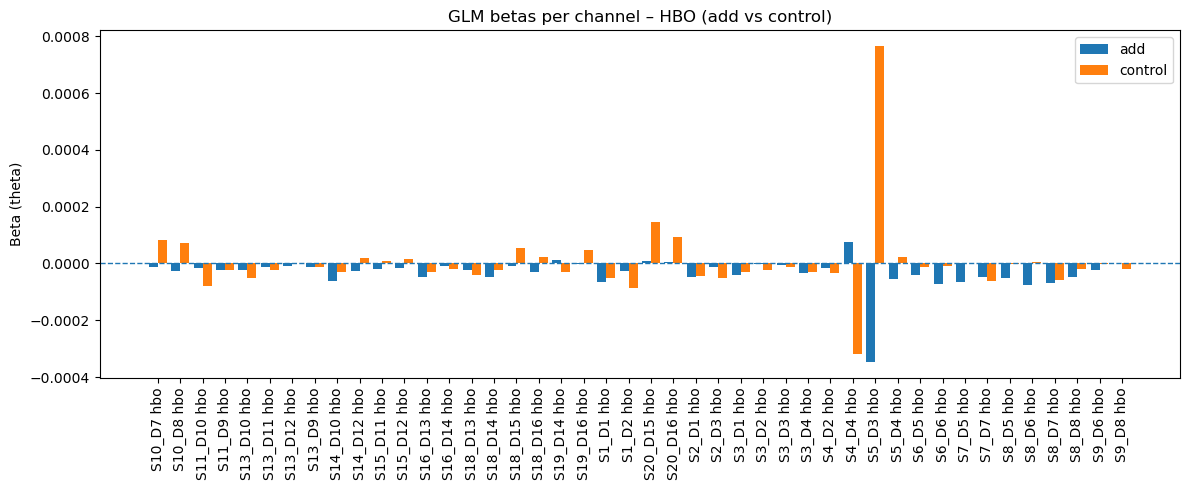

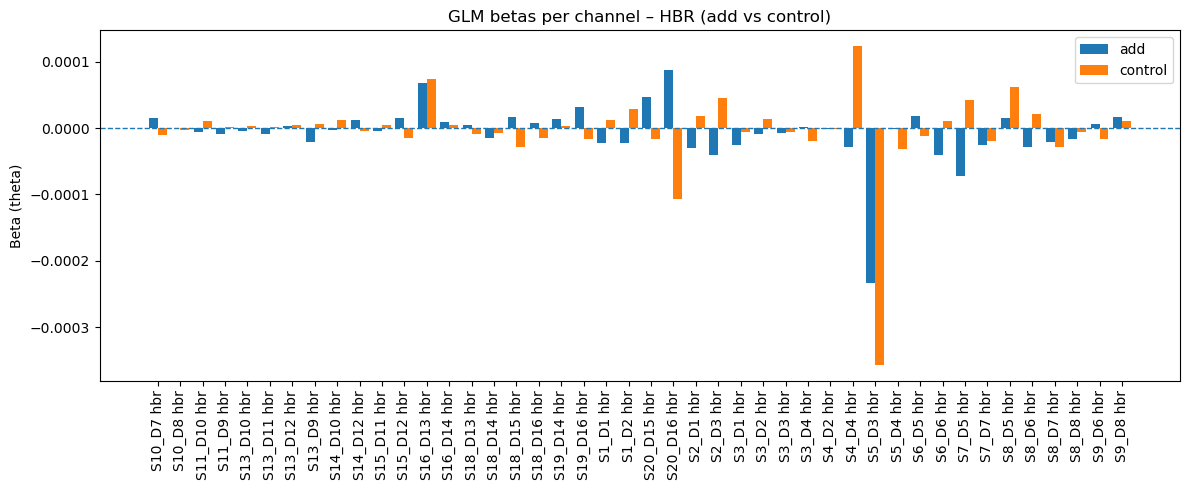


Creating heatmap of HbO betas (add/control)...


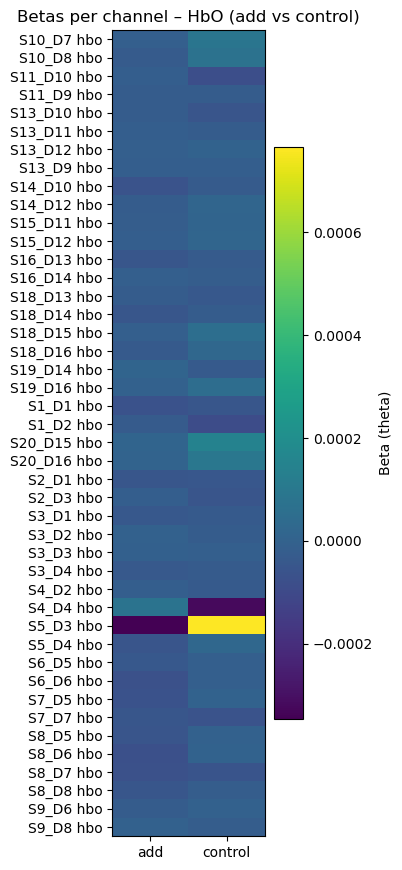


Creating volcano-style scatter for 'add' condition...


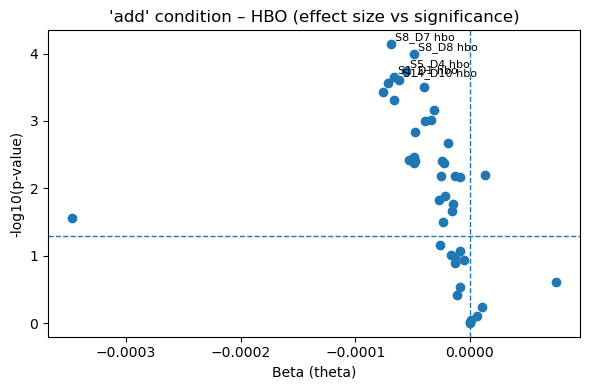

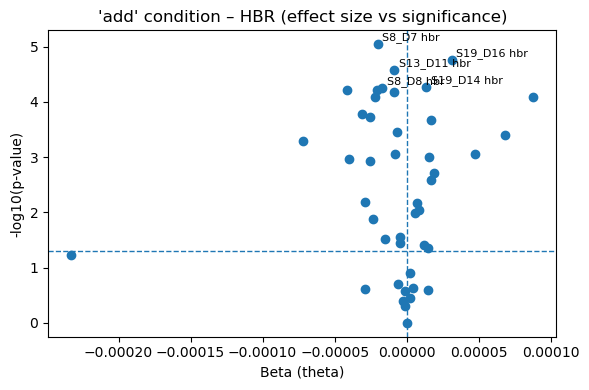


Done. Figures have been displayed.


In [18]:
# plot_glm_from_csv.py
#
# Read MNE-NIRS GLM results saved with RegressionResults.to_dataframe()
# and generate several intuitive plots.
#
# Assumes the CSV has columns like:
#   Condition, Chroma, ch_name, theta, se, t, p_value, ...
# which is the standard mne_nirs format.

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

subject_2 = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/glm_results_bnkg.csv"
subject_1 = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_DY/ses-tp1arith/nirs-homer3/3cond/glm_results_bndy.csv"

# ---------------------------------------------------------------------
# 0) INPUTS
# ---------------------------------------------------------------------
CSV_PATH = Path(subject_2)
ALPHA = 0.05  # p-value threshold for "significant"

# ---------------------------------------------------------------------
# 1) LOAD DATA
# ---------------------------------------------------------------------
print(f"Loading GLM results from: {CSV_PATH}")
df = pd.read_csv(CSV_PATH)

print("\nColumns in file:")
print(df.columns.tolist())

# Basic sanity checks
required_cols = {"Condition", "Chroma", "ch_name", "theta", "p_value"}
missing = required_cols.difference(df.columns)
if missing:
    raise RuntimeError(f"CSV is missing columns: {missing}")

# Make sure string columns really are strings
df["Condition"] = df["Condition"].astype(str)
df["Chroma"] = df["Chroma"].astype(str)
df["ch_name"] = df["ch_name"].astype(str)

# ---------------------------------------------------------------------
# 2) TEXT SUMMARY: SIGNIFICANT CHANNELS
# ---------------------------------------------------------------------
sig = df[df["p_value"] < ALPHA]

summary = (
    sig.groupby(["Condition", "Chroma"])["ch_name"]
       .nunique()
       .reset_index(name="n_sig_channels")
)

print("\nNumber of significant channels (p < {:.3f}) "
      "per condition & chroma:".format(ALPHA))
print(summary.to_string(index=False))

# ---------------------------------------------------------------------
# Helper: ensure consistent channel order
# ---------------------------------------------------------------------
def _order_channels(sub_df):
    """Return sub_df sorted by channel name and with unique ch_name index."""
    return sub_df.sort_values("ch_name").set_index("ch_name")


# ---------------------------------------------------------------------
# 3) BAR PLOTS: BETAS PER CHANNEL FOR ADD & CONTROL
# ---------------------------------------------------------------------
print("\nCreating bar plots for 'add' and 'control' betas per channel...")

conditions_of_interest = ["add", "control"]
chroma_list = sorted(df["Chroma"].unique())

for chroma in chroma_list:
    df_ch = df[(df["Chroma"] == chroma) &
               (df["Condition"].isin(conditions_of_interest))]

    if df_ch.empty:
        continue

    # Split by condition and align by channel name
    df_add = _order_channels(df_ch[df_ch["Condition"] == "add"])
    df_ctrl = _order_channels(df_ch[df_ch["Condition"] == "control"])

    # if one condition is missing for this chroma, skip
    if df_add.empty or df_ctrl.empty:
        continue

    # Align channels
    common_channels = df_add.index.intersection(df_ctrl.index)
    df_add = df_add.loc[common_channels]
    df_ctrl = df_ctrl.loc[common_channels]

    x = np.arange(len(common_channels))
    width = 0.4

    fig, ax = plt.subplots(figsize=(12, 5))
    ax.bar(x - width / 2, df_add["theta"], width, label="add")
    ax.bar(x + width / 2, df_ctrl["theta"], width, label="control")

    ax.axhline(0.0, linestyle="--", linewidth=1)
    ax.set_xticks(x)
    ax.set_xticklabels(common_channels, rotation=90)
    ax.set_ylabel("Beta (theta)")
    ax.set_title(f"GLM betas per channel – {chroma.upper()} (add vs control)")
    ax.legend()
    fig.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 4) HEATMAP: HbO BETAS (ADD & CONTROL)
# ---------------------------------------------------------------------
print("\nCreating heatmap of HbO betas (add/control)...")

if "hbo" in df["Chroma"].unique():
    df_hbo = df[
        (df["Chroma"] == "hbo") &
        (df["Condition"].isin(conditions_of_interest))
    ]
    if not df_hbo.empty:
        heat = df_hbo.pivot(index="ch_name",
                            columns="Condition",
                            values="theta")
        heat = heat.sort_index()

        fig, ax = plt.subplots(
            figsize=(4, max(4, len(heat) * 0.2))
        )
        im = ax.imshow(heat.values, aspect="auto")

        ax.set_xticks(np.arange(heat.shape[1]))
        ax.set_xticklabels(heat.columns)
        ax.set_yticks(np.arange(heat.shape[0]))
        ax.set_yticklabels(heat.index)

        ax.set_title("Betas per channel – HbO (add vs control)")
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label("Beta (theta)")

        fig.tight_layout()
        plt.show()
    else:
        print("No HbO rows for add/control found in CSV.")
else:
    print("No HbO data in CSV – skipping heatmap.")

# ---------------------------------------------------------------------
# 5) VOLCANO PLOT: ADD CONDITION (BETA VS -log10(p))
# ---------------------------------------------------------------------
print("\nCreating volcano-style scatter for 'add' condition...")

for chroma in chroma_list:
    df_add = df[(df["Condition"] == "add") & (df["Chroma"] == chroma)]
    if df_add.empty:
        continue

    # Avoid log(0) – clip extremely small p-values
    p = df_add["p_value"].clip(lower=1e-10)
    neg_log_p = -np.log10(p)

    fig, ax = plt.subplots(figsize=(6, 4))
    ax.scatter(df_add["theta"], neg_log_p)

    ax.axvline(0.0, linestyle="--", linewidth=1)
    # horizontal line for p = 0.05
    ax.axhline(-np.log10(ALPHA), linestyle="--", linewidth=1)

    ax.set_xlabel("Beta (theta)")
    ax.set_ylabel("-log10(p-value)")
    ax.set_title(f"'add' condition – {chroma.upper()} (effect size vs significance)")

    # Label the most extreme points (top 5 by -log10(p))
    top = df_add.assign(neg_log_p=neg_log_p).nlargest(5, "neg_log_p")
    for _, row in top.iterrows():
        ax.annotate(
            row["ch_name"],
            (row["theta"], -np.log10(max(row["p_value"], 1e-10))),
            xytext=(3, 3),
            textcoords="offset points",
            fontsize=8,
        )

    fig.tight_layout()
    plt.show()

print("\nDone. Figures have been displayed.")


In [10]:
subject_2 = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_KG/ses-tp1arith/nirs-homer3/3cond/glm_results_bnkg.csv"
subject_1 = "/Users/divijnalge/Library/CloudStorage/OneDrive-NanyangTechnologicalUniversity/ntu/Brain Norm/Brain_Norm_Files/fNIRS preproc/BN_DY/ses-tp1arith/nirs-homer3/3cond/glm_results_bndy.csv"


In [11]:
#Compare significant channels

import pandas as pd

def sig_summary(csv, alpha=0.05):
    df = pd.read_csv(csv)
    sig = df[df["p_value"] < alpha]
    return (
        sig.groupby(["Condition", "Chroma"])["ch_name"]
           .nunique()
           .reset_index(name="n_sig_channels")
    )

print("Subj 1:")
print(sig_summary(subject_1))

print("\nSubj 2:")
print(sig_summary(subject_2))


Subj 1:
   Condition Chroma  n_sig_channels
0        add    hbo              30
1        add    hbr              33
2   constant    hbo              31
3   constant    hbr              17
4    control    hbo              30
5    control    hbr              23
6    drift_1    hbo              19
7    drift_1    hbr              25
8    drift_2    hbo              12
9    drift_2    hbr               9
10   drift_3    hbo              32
11   drift_3    hbr              25

Subj 2:
   Condition Chroma  n_sig_channels
0        add    hbo              17
1        add    hbr              33
2   constant    hbo               5
3   constant    hbr              16
4    control    hbo              13
5    control    hbr              16
6    drift_1    hbo               9
7    drift_1    hbr              21
8    drift_2    hbo               8
9    drift_2    hbr               5
10   drift_3    hbo               7
11   drift_3    hbr              23
12   drift_4    hbo              20
13   drift_

In [12]:
#Compare beta patterns

df1 = pd.read_csv(subject_1)
df2 = pd.read_csv(subject_2)

cond = "add"
chroma = "hbo"

s1 = df1[(df1["Condition"] == cond) & (df1["Chroma"] == chroma)]
s2 = df2[(df2["Condition"] == cond) & (df2["Chroma"] == chroma)]

s1 = s1.set_index("ch_name")["theta"]
s2 = s2.set_index("ch_name")["theta"]

common_ch = s1.index.intersection(s2.index)

# quick correlation of beta patterns
corr = s1.loc[common_ch].corr(s2.loc[common_ch])
print(f"Correlation of {cond} {chroma} betas across subjects: {corr:.2f}")


Correlation of add hbo betas across subjects: 0.06


In [13]:
# Compare Roi Channels

roi_channels = ["S1_D1 hbo", "S2_D1 hbo"]  # your chosen ROI labels

def roi_beta(csv, cond, chroma, ch_list):
    df = pd.read_csv(csv)
    sub = df[
        (df["Condition"] == cond) &
        (df["Chroma"] == chroma) &
        (df["ch_name"].isin(ch_list))
    ]
    return sub["theta"].mean()

print("Subj1 ROI add HbO:", roi_beta(subject_1, "add", "hbo", roi_channels))
print("Subj2 ROI add HbO:", roi_beta(subject_2, "add", "hbo", roi_channels))


Subj1 ROI add HbO: -5.701198040095502e-05
Subj2 ROI add HbO: -2.1238505146789906e-05
